**Coding Resources**
- https://github.com/lestercardoz11/SP-500-index-anomaly-detection - (S&P 500 anomaly detection repository)
- https://curiousily.com/posts/anomaly-detection-in-time-series-with-lstms-using-keras-in-python/ - (S&P 500 anomaly detection tutorial)
- https://curiousily.com/posts/time-series-anomaly-detection-using-lstm-autoencoder-with-pytorch-in-python/ - (pytorch LSTM implementation tutorial)

In [4]:
import torch.nn as nn
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np
import torch

**S&P 500 Daily Prices 1986-2018**

In [5]:
filepath = './data/spx.csv'
df = pd.read_csv(filepath)
print(df.shape)
df.head()

(8192, 2)


,date,close
0,02-Jan-86,209.59
1,03-Jan-86,210.88
2,06-Jan-86,210.65
3,07-Jan-86,213.80
4,08-Jan-86,207.97


**Visualize Data**

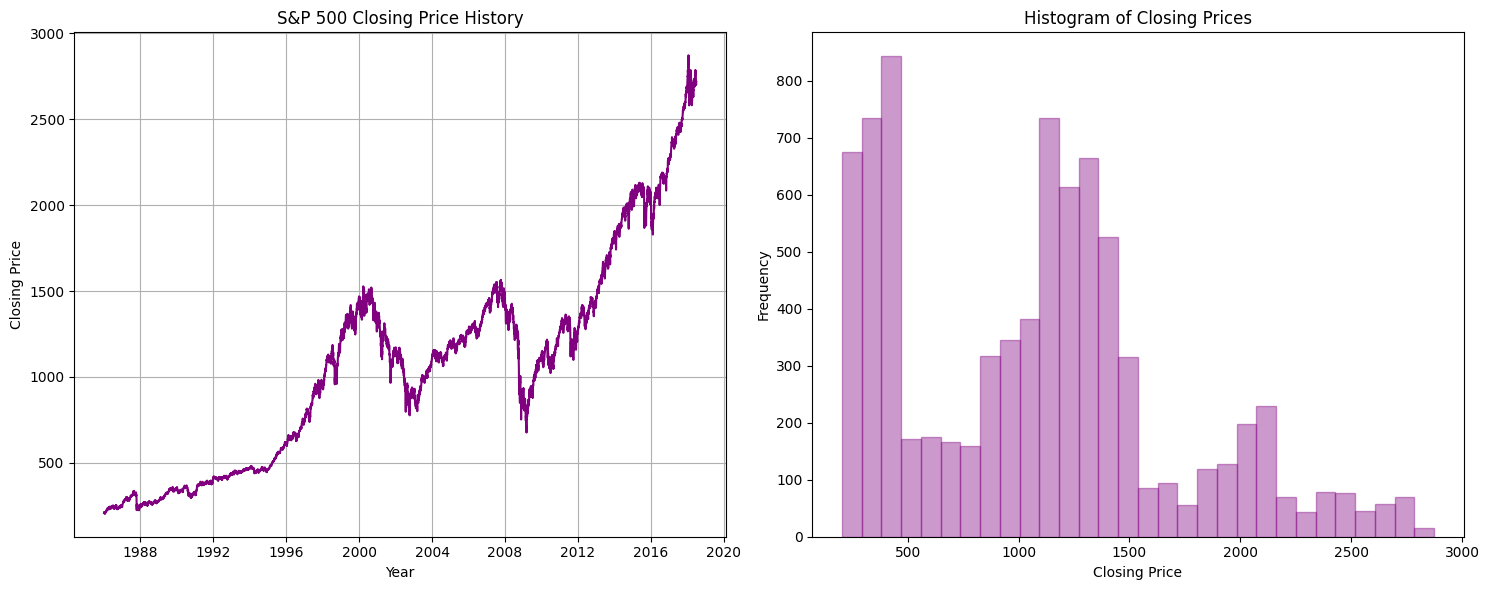

In [6]:
df['date'] = pd.to_datetime(df['date'], format='%d-%b-%y')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# plot time series data
ax1.plot(df['date'], df['close'], color='purple')
ax1.set_xlabel('Year')
ax1.set_ylabel('Closing Price')
ax1.set_title('S&P 500 Closing Price History')
ax1.grid(True)

# plot histogram
ax2.hist(df['close'], bins=30, color='purple', edgecolor='purple', alpha=0.4, histtype='bar')
ax2.set_title('Histogram of Closing Prices')
ax2.set_xlabel('Closing Price')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

**Split & Standardize Data**
- fix for train, validation, test

In [7]:
# split data
train_size = int(len(df) * 0.95)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(7782, 2) (410, 2)


In [8]:
# scalar fit to training data
scaler = StandardScaler()
scaler.fit(train[['close']])

# standardize train and test data
train.loc[:, 'close'] = scaler.transform(train[['close']])
test.loc[:, 'close'] = scaler.transform(test[['close']])
print("Train Mean:", train['close'].mean(), "Train Standard Deviation:", train['close'].std())
print("Test Mean:", test['close'].mean(), "Test Standard Deviation:", test['close'].std())

Train Mean: 3.5061476552541565e-16 Train Standard Deviation: 1.0000642570281786
Test Mean: 2.8503784420683367 Test Standard Deviation: 0.32960277554289286


**Prepare Dataset**

In [8]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []

    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [ ]:
TIME_STEPS = 30

X_train, y_train = create_dataset(
  train[['close']],
  train.close,
  TIME_STEPS
)

X_test, y_test = create_dataset(
  test[['close']],
  test.close,
  TIME_STEPS
)

#print(X_train.shape)

**LSTM Autoencoder**

In [9]:
class Encoder(nn.Module):

    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(Encoder, self).__init__()
        self.seq_len = seq_len
        self.n_features = n_features
        self.embedding_dim = embedding_dim
        self.hidden_dim = embedding_dim, 2 * embedding_dim

        self.rnn1 = nn.LSTM(
            input_size=n_features,
            hidden_size=self.hidden_dim,
            num_layers=1,
            batch_first=True
        )

        self.rnn2 = nn.LSTM(
            input_size=self.hidden_dim,
            hidden_size=embedding_dim,
            num_layers=1,
            batch_first=True
        )

    def forward(self, x):
        x = x.reshape((1, self.seq_len, self.n_features))
        x, (_, _) = self.rnn1(x)
        x, (hidden_n, _) = self.rnn2(x)
        return hidden_n.reshape((self.n_features, self.embedding_dim))

In [10]:
class Decoder(nn.Module):

    def __init__(self, seq_len, input_dim=64, n_features=1):
        super(Decoder, self).__init__()
        self.seq_len = seq_len
        self.input_dim = input_dim
        self.n_features = n_features
        self.hidden_dim = 2 * input_dim, n_features

        self.rnn1 = nn.LSTM(
            input_size=input_dim,
            hidden_size=input_dim,
            num_layers=1,
            batch_first=True
        )

        self.rnn2 = nn.LSTM(
            input_size=input_dim,
            hidden_size=self.hidden_dim,
            num_layers=1,
            batch_first=True
        )

        self.output_layer = nn.Linear(self.hidden_dim, n_features)

    def forward(self, x):
        x = x.repeat(self.seq_len, self.n_features)
        x = x.reshape((self.n_features, self.seq_len, self.input_dim))
        x, (hidden_n, cell_n) = self.rnn1(x)
        x, (hidden_n, cell_n) = self.rnn2(x)
        x = x.reshape((self.seq_len, self.hidden_dim))

        return self.output_layer(x)

In [11]:
class LSTMAutoencoder(nn.Module):

    def __init__(self, device, seq_len, n_features, embedding_dim=64):
        super(LSTMAutoencoder, self).__init__()
        self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
        self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

**Training Loop**

In [12]:
def train_model(model, device, train_dataset, optimizer, criterion):
    model.train()
    train_losses = []

    for seq_true in train_dataset:
        optimizer.zero_grad()
        seq_true = seq_true.to(device)
        seq_pred = model(seq_true)
        loss = criterion(seq_pred, seq_true)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    return train_losses

In [13]:
def validate_model(model, device, val_dataset, criterion):
    model.eval()
    val_losses = []

    with torch.no_grad():
        for seq_true in val_dataset:
            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)
            loss = criterion(seq_pred, seq_true)
            val_losses.append(loss.item())

    return val_losses

In [14]:
def train_model_full(model, train_dataset, val_dataset, optimizer, criterion, n_epochs):
    history = {'train': [], 'val': []}
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10000.0

    for epoch in range(1, n_epochs + 1):
        train_losses = train_model(model, train_dataset, optimizer, criterion)
        val_losses = validate_model(model, val_dataset, criterion)

        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)
        history['train'].append(train_loss)
        history['val'].append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

        print(f'Epoch {epoch}: train loss {train_loss}, val loss {val_loss}')

    model.load_state_dict(best_model_wts)

    return model.eval(), history

**Training Evaluation**

In [15]:
model = LSTMAutoencoder(seq_len, n_features, 128, criterion)
model = model.to(device)

# train model

# print out training and validation loss

NameError: name 'seq_len' is not defined

**Testing Evaluation/Visualization**